In [ ]:
import os
import torch
import math
import json
import random
import shutil
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torchvision import datasets
from dataclasses import dataclass
from typing import List, Dict, Any
from torch.utils.data import DataLoader, random_split
from transformers import AutoImageProcessor, AutoModel, AutoConfig, get_cosine_schedule_with_warmup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/AIC Data/Project/Algae.v6i.coco.zip" -d "/content/drive/MyDrive/AIC Data/Project/dataset"

# Data Prep

In [ ]:
def coco_to_classification(
    coco_json_path,
    images_dir,
    output_dir,
    split="train"
):
    """
    Converts COCO annotations into a folder-based classification dataset.
    One copy per image using its **majority category** (first annotation if multiple).
    """
    # Load COCO JSON
    with open(coco_json_path, 'r') as f:
        coco = json.load(f)

    # Create category ID → category name lookup
    categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

    # Build mapping from image_id → category name
    image_to_category = {}

    for ann in coco["annotations"]:
        image_id = ann["image_id"]
        category_id = ann["category_id"]
        category_name = categories[category_id]

        # Only use the first label if multiple annotations exist
        if image_id not in image_to_category:
            image_to_category[image_id] = category_name

    print("Number of labeled images:", len(image_to_category))

    # Process each image entry
    for img in tqdm(coco["images"], desc=f"Processing {split} set"):
        image_id = img["id"]
        file_name = img["file_name"]

        # Skip images without annotations
        if image_id not in image_to_category:
            continue

        class_name = image_to_category[image_id]

        src = os.path.join(images_dir, file_name)
        dst = os.path.join(output_dir, split, class_name)

        os.makedirs(dst, exist_ok=True)
        shutil.copy(src, os.path.join(dst, file_name))

In [ ]:
coco_root = "/content/drive/MyDrive/AIC Data/Project/dataset"
output_root = "/content/drive/MyDrive/AIC Data/Project/dataset_MostCommon"

In [ ]:
ds = ["train", "valid", "test"]

for split in ds:
    coco_json = os.path.join(coco_root, split, "_annotations.coco.json")
    images_folder = os.path.join(coco_root, split)

    if os.path.exists(coco_json):
        coco_to_classification(
            coco_json_path=coco_json,
            images_dir=images_folder,
            output_dir=output_root,
            split=split
        )

Number of labeled images: 1524


Processing train set: 100%|██████████| 1930/1930 [11:05<00:00,  2.90it/s]


Number of labeled images: 438


Processing valid set: 100%|██████████| 551/551 [04:49<00:00,  1.90it/s]


Number of labeled images: 225


Processing test set: 100%|██████████| 281/281 [02:27<00:00,  1.91it/s]


In [ ]:
train_dataset = datasets.ImageFolder(root=os.path.join(output_root, 'train'))
valid_dataset = datasets.ImageFolder(root=os.path.join(output_root, 'valid'))
test_dataset = datasets.ImageFolder(root=os.path.join(output_root, 'test'))

In [ ]:
num_train_classes = len(train_dataset.classes)
print("# of training classes:", num_train_classes, train_dataset.classes)
num_valid_classes = len(valid_dataset.classes)
print("# of validation classes:", num_valid_classes, valid_dataset.classes)
num_test_classes = len(test_dataset.classes)
print("# of test classes:", num_test_classes, test_dataset.classes)

# of training classes: 17 ['Algae', 'Clam Shell', 'Elodea Canadensis', 'Eriocaulon Septangulare', 'Leaves', 'M. Spicatum', 'M. Tenellum', 'Najas', 'P. Amplifolius', 'P. Gramineus', 'P. Perfoliatus', 'P. Praelongus', 'P. Robbinsii', 'P. Zosteriformis', 'Snail', 'Unknown Plant', 'Vallisneria Americana']
# of validation classes: 17 ['Algae', 'Clam Shell', 'Elodea Canadensis', 'Eriocaulon Septangulare', 'Leaves', 'M. Spicatum', 'M. Tenellum', 'Najas', 'P. Amplifolius', 'P. Gramineus', 'P. Perfoliatus', 'P. Praelongus', 'P. Robbinsii', 'P. Zosteriformis', 'Snail', 'Unknown Plant', 'Vallisneria Americana']
# of test classes: 16 ['Algae', 'Clam Shell', 'Elodea Canadensis', 'Eriocaulon Septangulare', 'Leaves', 'M. Spicatum', 'M. Tenellum', 'Najas', 'P. Amplifolius', 'P. Gramineus', 'P. Perfoliatus', 'P. Praelongus', 'P. Robbinsii', 'P. Zosteriformis', 'Snail', 'Unknown Plant']


# Training

In [ ]:
class DinoV3Linear(nn.Module):
    def __init__(self, backbone: AutoModel, num_classes: int, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = backbone
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
            self.backbone.eval()

        hidden_size = getattr(backbone.config, "hidden_size", None)
        self.head = nn.Linear(hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        last_hidden = outputs.last_hidden_state
        cls = last_hidden[:, 0]
        logits = self.head(cls)
        return logits

In [ ]:
from huggingface_hub import login
login(new_session=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
MODEL_NAME = "facebook/dinov3-vitb16-pretrain-lvd1689m"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
backbone = AutoModel.from_pretrained(MODEL_NAME)
image_processor_config = json.loads(image_processor.to_json_string())
backbone_config = json.loads(AutoConfig.from_pretrained(MODEL_NAME).to_json_string())

In [ ]:
freeze_backbone = True
model = DinoV3Linear(backbone, num_train_classes, freeze_backbone=freeze_backbone).to(device)

In [ ]:
BATCH_SIZE = 16
NUM_WORKERS = min(8, os.cpu_count() or 2)
EPOCHS = 15
LR = 7e-5
WEIGHT_DECAY = 1e-4
WARMUP_RATIO = 0.05
CHECKPOINT_DIR = "/content/drive/MyDrive/AIC Data/Project/weights"
EVAL_EVERY_STEPS = 120

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

@dataclass
class Collator:
    processor: AutoImageProcessor

    def __call__(self, batch):
        # unpack (image, label) tuples
        images, labels = zip(*batch)

        rgb_images = [img.convert("RGB") if isinstance(img, Image.Image) else img for img in images]

        inputs = self.processor(images=rgb_images, return_tensors="pt")
        labels = torch.tensor(labels, dtype=torch.long)

        return {"pixel_values": inputs["pixel_values"], "labels": labels}

collate_fn = Collator(image_processor)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn,
)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = EPOCHS * math.ceil(len(train_loader))
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
criterion = nn.CrossEntropyLoss()

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

/tmp/ipython-input-484019659.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [ ]:
def evaluate() -> Dict[str, float]:
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in valid_loader:
            pixel_values = batch["pixel_values"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True)
            logits = model(pixel_values)
            loss = criterion(logits, labels)
            loss_sum += loss.item() * labels.size(0)
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return {
        "val_loss": loss_sum / max(total, 1),
        "val_acc": correct / max(total, 1),
    }

In [ ]:
best_acc = 0.0
global_step = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    model.backbone.eval()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for i, batch in enumerate(train_loader, start=1):
        pixel_values = batch["pixel_values"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(pixel_values)
        loss = criterion(logits, labels)

        preds = logits.argmax(dim=-1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        global_step += 1

        if global_step % EVAL_EVERY_STEPS == 0:
            metrics = evaluate()
            train_loss_avg = running_loss / EVAL_EVERY_STEPS
            train_acc_avg = running_correct / running_total if running_total > 0 else 0.0

            print(
                f"[epoch {epoch} | step {global_step}] "
                f"train_loss={train_loss_avg:.4f} train_acc={train_acc_avg*100:.2f}% "
                f"val_loss={metrics['val_loss']:.4f} val_acc={metrics['val_acc']*100:.2f}%"
            )
            running_loss = 0.0
            running_correct = 0
            running_total = 0

            if metrics["val_acc"] > best_acc:
                best_acc = metrics["val_acc"]
                ckpt_path = os.path.join(CHECKPOINT_DIR, f"model_MostCommon.pt")
                torch.save(
                    {
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "scheduler_state_dict": scheduler.state_dict(),
                        "config": {
                            "model_name": MODEL_NAME,
                            "classes": train_dataset.classes,
                            "backbone": backbone_config,
                            "image_processor": image_processor_config,
                            "freeze_backbone": freeze_backbone,
                        },
                        "step": global_step,
                        "epoch": epoch,
                    },
                    ckpt_path,
                )

    metrics = evaluate()
    print(
        f"END EPOCH {epoch}: val_loss={metrics['val_loss']:.4f} val_acc={metrics['val_acc']*100:.2f}% "
        f"(best_acc={best_acc*100:.2f}%)"
    )

END EPOCH 1: val_loss=1.5427 val_acc=57.99% (best_acc=0.00%)
[epoch 2 | step 120] train_loss=0.2959 train_acc=58.33% val_loss=1.5311 val_acc=57.53%
END EPOCH 2: val_loss=1.4945 val_acc=59.13% (best_acc=57.53%)
[epoch 3 | step 240] train_loss=0.5812 train_acc=57.94% val_loss=1.4790 val_acc=58.68%
END EPOCH 3: val_loss=1.4585 val_acc=59.36% (best_acc=58.68%)
[epoch 4 | step 360] train_loss=0.8054 train_acc=61.81% val_loss=1.4379 val_acc=60.27%
END EPOCH 4: val_loss=1.4300 val_acc=60.50% (best_acc=60.27%)
[epoch 5 | step 480] train_loss=1.0664 train_acc=61.75% val_loss=1.4048 val_acc=61.42%
END EPOCH 5: val_loss=1.4048 val_acc=61.42% (best_acc=61.42%)
END EPOCH 6: val_loss=1.3846 val_acc=61.64% (best_acc=61.42%)
[epoch 7 | step 600] train_loss=0.2578 train_acc=60.16% val_loss=1.3814 val_acc=61.64%
END EPOCH 7: val_loss=1.3703 val_acc=62.33% (best_acc=61.64%)
[epoch 8 | step 720] train_loss=0.5191 train_acc=64.19% val_loss=1.3631 val_acc=62.10%
END EPOCH 8: val_loss=1.3588 val_acc=62.33% (

10 minutes on L4 GPU

# Example Predict

In [ ]:
import transformers
import glob
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
train_images = glob.glob("/content/drive/MyDrive/AIC Data/Project/dataset_MostCommon/train/*/*")
valid_images = glob.glob("/content/drive/MyDrive/AIC Data/Project/dataset_MostCommon/valid/*/*")
test_images = glob.glob("/content/drive/MyDrive/AIC Data/Project/dataset_MostCommon/test/*/*")

In [ ]:
def get_image_label(image_dir):
  return image_dir.split('/')[-2]

get_image_label(train_images[0])

'P. Amplifolius'

In [ ]:
ckpt_path = "/content/drive/MyDrive/AIC Data/Project/weights/model_MostCommon_best.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(ckpt_path, map_location=device)

ProcessorClass = getattr(transformers, ckpt["config"]["image_processor"]["image_processor_type"])
image_processor = ProcessorClass(**ckpt["config"]["image_processor"])
backbone = transformers.AutoModel.from_config(transformers.AutoConfig.for_model(**ckpt["config"]["backbone"]))
model = DinoV3Linear(
    backbone=backbone,
    num_classes=len(ckpt["config"]["classes"]),
    freeze_backbone=ckpt["config"].get("freeze_backbone", True),
).to(device)
classes = ckpt["config"]["classes"]

model.load_state_dict(ckpt["model_state_dict"])
model = model.eval()

In [ ]:
def infer(images, device):
    with torch.no_grad():
        inputs = image_processor(images=images, return_tensors="pt").to(device)
        logits = model(inputs["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        pred = probs.argmax(dim=-1)
        outputs = []
        for i in range(len(images)):
            conf = probs[i, pred[i]]
            pred_label = classes[pred[i]]
            true_label = get_image_label(images[i])
            outputs.append((true_label, pred_label, float(conf)))
        return outputs

In [ ]:
df = pd.DataFrame(columns=['Image', 'True Label', 'Predicted Label', 'Confidence'])

In [ ]:
for i in range(0, len(test_images), 16):
    print(f'processing: {i+16}/{len(test_images)}')
    image_paths = test_images[i:i+16]
    inferences = infer(image_paths, device)
    result = [(img_path,) + inference for img_path, inference in zip(image_paths, inferences)]
    df = pd.concat([df, pd.DataFrame(result, columns=df.columns)], ignore_index=True)

processing: 16/225


/tmp/ipython-input-1216580349.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(result, columns=df.columns)], ignore_index=True)


processing: 32/225
processing: 48/225
processing: 64/225
processing: 80/225
processing: 96/225
processing: 112/225
processing: 128/225
processing: 144/225
processing: 160/225
processing: 176/225
processing: 192/225
processing: 208/225
processing: 224/225
processing: 240/225


In [ ]:
df.tail()

,Image,True Label,Predicted Label,Confidence
220,/content/drive/MyDrive/AIC Data/Project/datase...,Unknown Plant,Algae,0.352403
221,/content/drive/MyDrive/AIC Data/Project/datase...,Unknown Plant,P. Amplifolius,0.286410
222,/content/drive/MyDrive/AIC Data/Project/datase...,Unknown Plant,Unknown Plant,0.333209
223,/content/drive/MyDrive/AIC Data/Project/datase...,Unknown Plant,Unknown Plant,0.335105
224,/content/drive/MyDrive/AIC Data/Project/datase...,Unknown Plant,Eriocaulon Septangulare,0.281757


In [ ]:
df['Confidence'].mean()

np.float64(0.5138441305690341)

In [ ]:
df_metrics = pd.DataFrame(columns=['Class Name', 'Precision', 'Recall', 'F1 Score', 'TP', 'FP', 'FN', 'Support'])

for label in classes:
    tp = len(df[(df['True Label'] == label) & (df['Predicted Label'] == label)])
    fp = len(df[(df['True Label'] != label) & (df['Predicted Label'] == label)])
    fn = len(df[(df['True Label'] == label) & (df['Predicted Label'] != label)])
    support = tp + fn
    precision = (tp) / ((tp + fp) if (tp + fp) > 0 else 1)
    recall = tp / ((tp + fn) if (tp + fn) > 0 else 1)
    f1_score = 2 * (precision * recall) / ((precision + recall) if (precision + recall) > 0 else 1)
    df_metrics = pd.concat([df_metrics, pd.DataFrame([(label, round(precision, 3), round(recall, 3), round(f1_score, 3), tp, fp, fn, support)], columns=df_metrics.columns)], ignore_index=True)

/tmp/ipython-input-3551760248.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([(label, round(precision, 3), round(recall, 3), round(f1_score, 3), tp, fp, fn, support)], columns=df_metrics.columns)], ignore_index=True)


In [ ]:
# get macro average and micro average from df_metrics
macro_precision = df_metrics['Precision'].mean()
macro_recall = df_metrics['Recall'].mean()
macro_f1_score = df_metrics['F1 Score'].mean()
micro_precision = sum(df_metrics['TP']) / (sum(df_metrics['TP']) + sum(df_metrics['FP']))
micro_recall = sum(df_metrics['TP']) / (sum(df_metrics['TP']) + sum(df_metrics['FN']))
micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
total_tp = df_metrics['TP'].sum()
total_fp = df_metrics['FP'].sum()
total_fn = df_metrics['FN'].sum()
total_support = df_metrics['Support'].sum()
df_metrics = pd.concat([df_metrics, pd.DataFrame([('Micro Average',
                                                   micro_precision,
                                                   micro_recall,
                                                   micro_f1_score,
                                                   '-', '-', '-', '-')], columns=df_metrics.columns)], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame([('Macro Average',
                                                   round(macro_precision, 3),
                                                   round(macro_recall, 3),
                                                   round(macro_f1_score, 3),
                                                   '-', '-', '-', '-')], columns=df_metrics.columns)], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame([('Total', '-', '-', '-',
                                                   total_tp,
                                                   total_fp,
                                                   total_fn,
                                                   total_support)], columns=df_metrics.columns)], ignore_index=True)

In [ ]:
print('Most Common')
df_metrics

Most Common


,Class Name,Precision,Recall,F1 Score,TP,FP,FN,Support
0,Algae,0.607,0.773,0.68,17,11,5,22
1,Clam Shell,0.533,0.842,0.653,16,14,3,19
2,Elodea Canadensis,0.0,0.0,0.0,0,0,5,5
3,Eriocaulon Septangulare,0.636,0.5,0.56,7,4,7,14
4,Leaves,1.0,0.333,0.5,3,0,6,9
5,M. Spicatum,0.0,0.0,0.0,0,0,2,2
6,M. Tenellum,0.0,0.0,0.0,0,0,1,1
7,Najas,0.0,0.0,0.0,0,0,5,5
8,P. Amplifolius,0.648,0.907,0.756,68,37,7,75
9,P. Gramineus,0.0,0.0,0.0,0,0,6,6


Predicted: P. Robbinsii, Conf: 0.36265838146209717


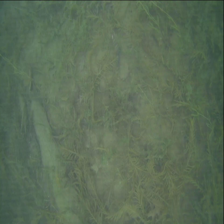

In [ ]:
image_path = np.random.choice(train_images)
image = Image.open(image_path)
pred, conf = infer(image, device)
print(f"Predicted: {pred}, Conf: {conf}")
display(image.resize((224, 224)))

In [ ]:
plt.figure(figsize = (20,20))
for i, idx in enumerate(np.random.choice(len(train_images), size=5, replace=False)):
    image = Image.open(train_images[idx])
    label = os.path.basename(os.path.dirname(train_images[idx]))
    pred, conf = infer(train_images, device)

    plt.subplot(5, 6, i+1)
    plt.imshow(train_images.resize((224, 224)))
    plt.title(f"Gth: {label}\nPred: {pred}\nConf: {conf}", fontdict = {'fontsize' : 8})
    plt.axis("off")